# Label CDK2 conformations

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import pytraj as pyt
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

### Load the DataFrame with the PDB entries metadata

In [2]:
prot_name = 'cdk2'
file = f'./df_metadata_{prot_name}_pdbids_LIGS.pkl'
df_prot_lig = pd.read_pickle(file)

## Load all the PDB structures as a conformational ensemble
- Load all the conformations (`pdb` files) using `pytraj`

In [3]:
ROOT_DIR = '../../data/crystal_confs/'

# Create a crystallographic ensemble (pseudo trajectory)
ENS_CONFS_DIR = f'{ROOT_DIR}/pdb_ensemble'
input_files = sorted(glob(f'{ENS_CONFS_DIR}/*_ENS.pdb'))

# Make sure the order of conformations in `input_files` 
# and `pdb_ids` is the same
input_files_basenames = [i.split('/')[-1].replace('_ENS.pdb', '') 
                         for i in input_files]
assert np.all(df_prot_lig['PDB_ID'] == input_files_basenames)

In [4]:
# Use `pytraj` to load all conformations
crys_traj = pyt.iterload(input_files, top = input_files[0])
crys_traj

pytraj.TrajectoryIterator, 418 frames: 
Size: 0.045295 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, non-PBC>
           

## Label PDB Structures

### Conformation types:

| Conformation Type | PDB Entry       |  Criteria |  
| :- |:------------- | :--
|**Active**|<mark style="background-color: #FFBAAD">1fin</mark>| Salt bridge between Lys33-Glu51 | 
|**Inactive** Src-Like|<mark style="background-color: #B0E6EA">4kku</mark>| No Lys33-Glu51 interaction |
|**Inactive** Open|<mark style="background-color: #FAE5BF">3pxf</mark>| $\alpha$C displacement from $\beta_4$ and $\beta_5$ sheets, forming an allosteric binding site |
|**Inactive** DFG-out|<mark style="background-color: #D5BFFA">5a14</mark>| Asp145 and Phe146 flipped & Phe146 oriented towards the pocket|


![CDK2_main_conformations](./CDK2_main_conformations.png "CDK2 Confs.")



### Criteria for label a given CDK2 conformation:

```python
if Lys33-Glu51 salt bridge exists:
    if Asp145 and Phe146 are flipped:
        label = DFG-out
    else:
        label = Active
else:
    if alphaC is displaced:
        label = Open
    else:
        label = Src-like
```

###  Functions to evaluate the above criteria
- The following functions will be used to evaluate each criterion described above. These functions are implemented in the `label_cdk2_confs.py` module, inside `helper_modules`. 

#### Does the `Lys33-Glu51` salt bridge exist?
- Measure the distance between atoms `:33@NZ` and `:51@CD`.
- If the distance is lower than 7.0 Angstroms, the salt bridge exists.
```python
# Evaluates if the salt bridge between LYS33-GLU51 exists
saltbridge_cutoff = 7.0
is_salt_bridge = get_distance_ij(traj_obj, ':33@NZ', ':51@CD') < saltbridge_cutoff
````

#### Are `Asp145` and `Phe146`  Flipped?
1. Measures the phi angle at position 145 (Asp145).
    - We will use the conformations `5a14` (true `DFG-out`) as the references for this criterion.
        - In the `5a14` DFG-in conformation, the value of the phi angle of ASP is -138.7.
        - We will use 110.0 as the cutoff value.
2. Determine how close to the pocket is Phe146 by measuring the distance of the $C \gamma$ of Phe146 and a residue of reference belonging to the pocket ($C \alpha$ of Gly11):
    - We will use the conformations `5a14` (true DFG-out), `5nev`, and `1jvp` as references.
        - In the `5a14` DFG-in conformation, the distance between `:146@CG` and `:11@CA` is 6.4 Angstroms.
        - We will use 7.0 A as the cutoff value.
As a result, the two properties, along with the `Lys33-Glu51` salt bridge, will determine whether label a given conformation as DFG-out:
- ASP145 and Phe146 are flipped if:
    - The absolute value of the phi angle at position 145 is above 120.0.
    - The distance between `:146@CG` and `:11@CA` is above 7.0 Angstroms.

```python
dfg_angle_cutoff = 110.0
d145_angle = np.absolute(get_phi_angle(traj_obj, residue = 145)) > dfg_angle_cutoff

dist_PHE146_GLY11 = 7.0
phe146_gly11_dist = get_distance_ij(crys_traj, ':146@CG', ':11@CA')

is_dfgout = (d145_angle > dfg_angle_cutoff) & (phe146_gly11_dist < dist_PHE146_GLY11)
```


#### Is the $\alpha$C helix displaced from $\beta_4$ and $\beta_5$ sheets?

- Measures the distance between geometric centers of $\alpha$C helix (residues 46 to 57) and the residues belonging to the $\beta_4$ and $\beta_5$ sheets (66-72, 75-81).
    - This residues are mentioned in the UniProt entry of CDK2.
- We will use the conformation `3pxf` as the reference for this criterion.
    - In the `3pxf` conformation (and other conformations including the 2AN ligand) the distance between these atom groups is greater than 15.0 Angstroms.
    - We will use 13.5 Angstroms as the cutoff value.
- If the distance is greater than 13.5 Angstroms, then the conformation is open.

```python
aC_b4b5_dist_cutoff = 13.5
is_aC_displaced = get_geom_center_distance(traj_obj, 
                            ':46-57', ':66-72,75-81') > aC_b4b5_dist_cutoff
```

### Implement the functions to label CDK2 conformations

In [5]:
from helper_modules.label_cdk2_confs import *

In [6]:
%%time
labels = label_cdk2_conformations(traj_obj = crys_traj, 
                         saltbridge_cutoff   = 7.0,
                         dfg_angle_cutoff    = 110.0,
                         aC_b4b5_dist_cutoff = 13.5,
                         dist_PHE146_GLY11   = 12.0)

CPU times: user 2.59 s, sys: 221 ms, total: 2.81 s
Wall time: 2.82 s


In [7]:
df_prot_lig['ConfTypeLabel'] = labels
df_prot_lig['ConfTypeLabel'].value_counts()

inact_src    292
active       120
inact_ope      5
dfg_out        1
Name: ConfTypeLabel, dtype: int64

## Visualize the above properties

In [8]:
df_prot_lig['salt_bridge_33_51'] = get_distance_ij(crys_traj, 
                                                   ':33@NZ', ':51@CD')
df_prot_lig['aCB4B5_distance']   = get_geom_center_distance(crys_traj, 
                                                            ':46-57', ':66-72,75-81')
df_prot_lig['dfg_angle_abs']     = np.absolute(
                                        get_phi_angle(crys_traj, residue = 145))
df_prot_lig['dist_PHE146_GLY11'] = get_distance_ij(crys_traj, ':146@CG', ':11@CA')

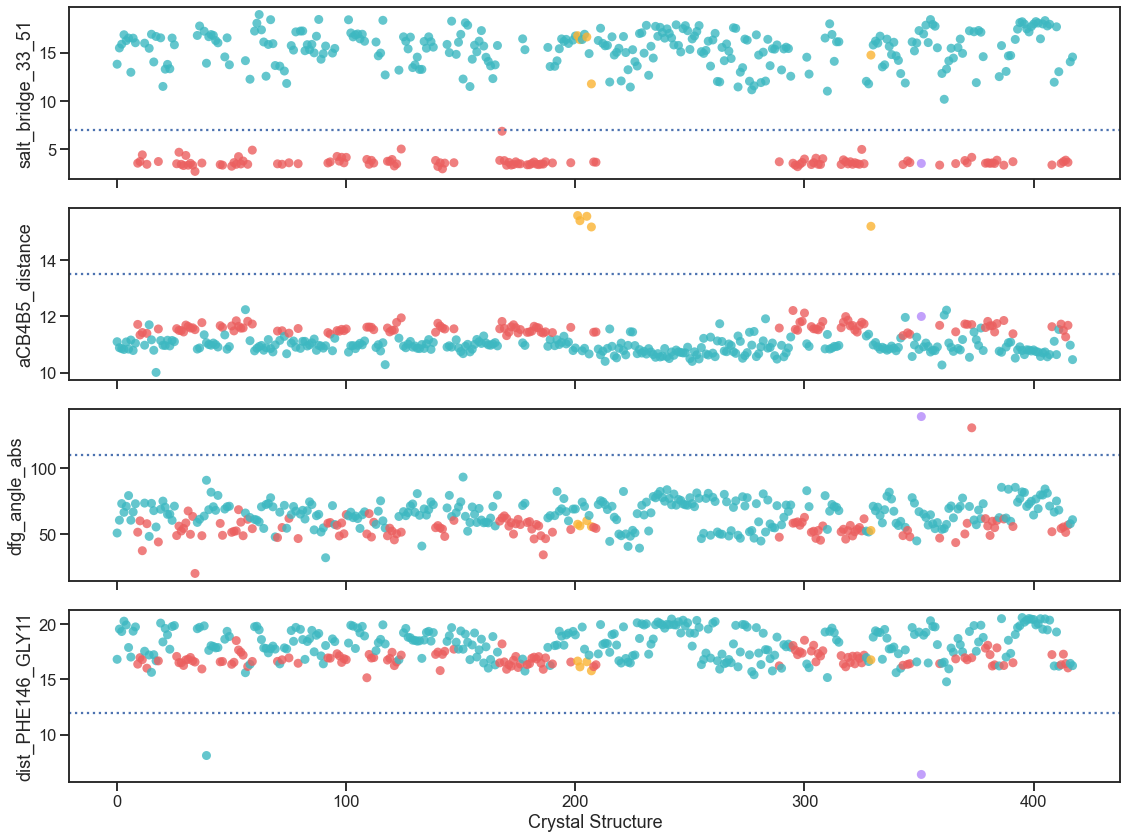

In [9]:
type_confs_names  = ['inact_src', 'active', 'inact_ope', 'dfg_out']
ref_confs_names   = ['4fku', '1fin', '3pxf', '5a14']
ref_confs_colors  = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
conf_label_colors = dict(zip(type_confs_names, ref_confs_colors))

df_ = df_prot_lig.reset_index()
fig, axs = plt.subplots(4, 1, figsize = (16, 12), sharex = True)

def plt_prop(ax, x, y, data, hue, cutoff):
    ax = sns.scatterplot(x = x, y = y,
            data = df_, hue = hue, legend = False,
            linewidth = 0, alpha = 0.8,
            palette = conf_label_colors, ax = ax)
    ax.axhline(y = cutoff, ls = ':')
    return ax
    
saltbridge_cutoff = 7.0
axs[0] = plt_prop(ax = axs[0], cutoff = saltbridge_cutoff,
                  x = 'index', y = 'salt_bridge_33_51',
                  data = df_, hue = 'ConfTypeLabel')

aC_b4b5_dist_cutoff = 13.5
axs[1] = plt_prop(ax = axs[1], cutoff = aC_b4b5_dist_cutoff,
                  x = 'index', y = 'aCB4B5_distance',
                  data = df_, hue = 'ConfTypeLabel')

dfg_angle_cutoff = 110.0
axs[2] = plt_prop(ax = axs[2], cutoff = dfg_angle_cutoff,
                  x = 'index', y = 'dfg_angle_abs',
                  data = df_, hue = 'ConfTypeLabel')
phe146_gly11_dist = 12
axs[3] = plt_prop(ax = axs[3], cutoff = phe146_gly11_dist,
                  x = 'index', y = 'dist_PHE146_GLY11',
                  data = df_, hue = 'ConfTypeLabel')
axs[3].set_xlabel('Crystal Structure')
plt.tight_layout()
plt.show()

In [10]:
df_prot_lig.query('ConfTypeLabel == "dfg_out"')

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,...,NonStndResnums,LigPktName,LigMW,LigNHeavyAtoms,LigDistToPocket,ConfTypeLabel,salt_bridge_33_51,aCB4B5_distance,dfg_angle_abs,dist_PHE146_GLY11
351,5a14,type ii inhibitors targeting cdk2.,2015-07-22,1,A,2.0,0.993,95.302,3,"[2, 10, 2]",...,None,LQ5,475.29771,36.0,6.435824,dfg_out,3.508649,11.99272,138.758612,6.405643


In [11]:
### Save the new DataFrame
filename = './df_metadata_cdk2_pdbids_LIGS_CONF-LABELS.pkl'
df_prot_lig.to_pickle(filename)

## Classical Multidimensional Scaling

In [12]:
# Implement mds
from helper_modules.classical_MDS import cMDS
from helper_modules.protein_subsequences import get_pisani_residues

In [13]:
pisani_residues = get_pisani_residues(sep=',')
pisani_mask = f':{pisani_residues}&(@CA)'

In [14]:
pair_rmsd_pisani = pyt.pairwise_rmsd(traj = crys_traj,
                                     mask = pisani_mask, 
                                     metric ='rms')
mds_pisani = cMDS(pair_rmsd_pisani)[0]

In [15]:
def plot_subspace(x, y, title = '', figsize = (8, 8), **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = figsize)
    sns.scatterplot(x = x, y = y, 
                    linewidth = 0, color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray', lw = 2.5)
    ax.axhline(0, ls = ':', color = 'gray', lw = 2.5)
    ax.grid()
    return ax

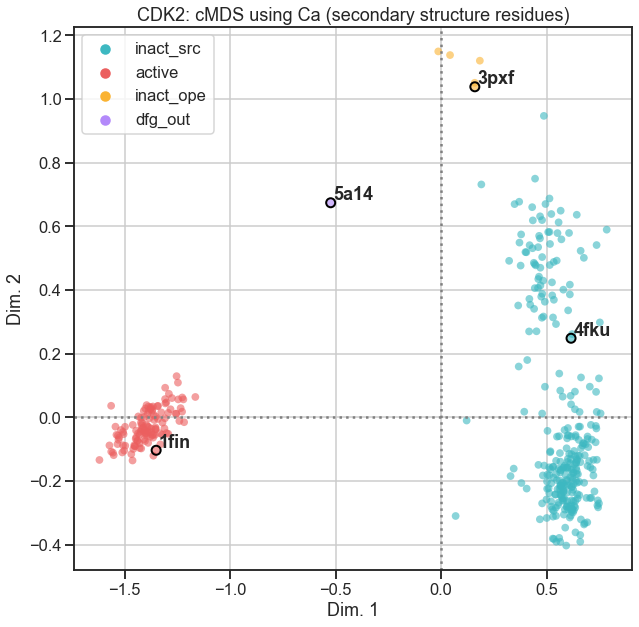

In [16]:
# Highlight the reference structures

df_ref_confs = df_prot_lig.loc[[i in ref_confs_names 
                 for i in df_prot_lig['PDB_ID']]]
df_ref_confs_idxs = df_ref_confs.index

# Plot the first two dims of the cMDS
x, y = mds_pisani[:2]
ax = plot_subspace(x, y, 
    title = 'CDK2: cMDS using Ca (secondary structure residues)',
             hue = df_prot_lig['ConfTypeLabel'],
    s = 60, alpha = 0.6, palette = conf_label_colors,
    figsize = (10, 10))
# Plot the reference conformations
sns.scatterplot(
    x = x[df_ref_confs_idxs],
    y = y[df_ref_confs_idxs],
    linewidth = 2, edgecolor = 'black',
    facecolors = 'none',
    ax = ax
)
for idx in df_ref_confs_idxs:
    plt.text(x[idx] + 0.01, y[idx] + 0.01, 
             s = df_prot_lig.iloc[idx]['PDB_ID'], fontweight = 'bold')

plt.show()